# Capstone 3 - Tumor Dectection from MRI image

This project involves training a deep learning model to automatically detect brain tumors in MRI scans. The project will focus on developing a model that can classify MRI images as either tumor (malignant/benign) or non-tumor, providing a valuable tool for radiologists and healthcare professionals.

# Data Wrangling and EDA

In [1]:
#Import libraries 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from tqdm import tqdm
import shutil
from sklearn.utils.class_weight import compute_class_weight

## Load Data

Since I don't want to put too much strain on computer's resorces, I started by creating a data frame with the file path of the MRI image and the label of the image. Images were labeled as no tumor, giloma, meningioma, and pituitary.  

Since my goal is a binary classification problem, tumor or no tumor, I will aslo convert these categorical labels to binary lables. I will keep the original lables for now as I might want to expand the model to multiclass classification in the future. 

In [2]:
# Path to the dataset folder
data_dir = r"C:\Users\Travi\OneDrive\Documents\GitHub\Springboard_Data_Science_Capstone_Project_3\Image_Data"

# Get all categories
categories = os.listdir(data_dir)

# Create DataFrame with image paths and their labels
data = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)
        data.append([img_path, category])
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)  

In [3]:
df.head()

,file_path,label
0,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma
1,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma
2,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma
3,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma
4,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,meningioma


## Encode Labels 

I will now encode the categorical labels to binary lables to be used for my binary classificaiton model. 

In [4]:
#Create binary labels
def convert_to_binary(label):
    return 0 if label == 'notumor' else 1

df['binary_label'] = df['label'].apply(convert_to_binary)

In [5]:
df.head()

,file_path,label,binary_label
0,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1
1,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1
2,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1
3,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1
4,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,meningioma,1


## Adding Image MetaData 

I will now add the image metadata, specifically image size and mode to the dataframe. 

In [6]:
# Add image sizes and modes to the data frame
def get_image_data(path):
    try:
        with Image.open(path) as img:
            return img.size, img.mode  # (width, height), mode
    except Exception as e:
        return None, None  # In case of corrupted image

# Apply to DataFrame
df[['image_size', 'image_mode']] = df['file_path'].apply(
    lambda path: pd.Series(get_image_data(path))
)

In [7]:
df.head()

,file_path,label,binary_label,image_size,image_mode
0,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1,"(512, 512)",RGB
1,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1,"(512, 512)",L
2,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1,"(512, 512)",L
3,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1,"(512, 512)",L
4,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,meningioma,1,"(314, 358)",RGB


In [8]:
# Inspect the image sizes and modes
print(df.image_size.unique())
print(df.image_mode.unique())

[(512, 512) (314, 358) (201, 251) (218, 234) (206, 245) (225, 225)
 (400, 400) (300, 168) (642, 361) (600, 450) (215, 234) (630, 630)
 (785, 848) (442, 442) (218, 231) (173, 201) (206, 244) (227, 222)
 (428, 417) (200, 252) (315, 315) (236, 290) (236, 263) (230, 282)
 (201, 250) (236, 236) (339, 340) (211, 236) (359, 449) (318, 354)
 (722, 690) (305, 337) (207, 243) (254, 198) (680, 680) (214, 236)
 (236, 300) (513, 522) (232, 217) (192, 192) (210, 234) (236, 223)
 (217, 248) (341, 377) (416, 395) (276, 326) (356, 474) (236, 269)
 (420, 264) (200, 223) (228, 221) (852, 480) (470, 432) (332, 442)
 (212, 280) (227, 213) (222, 252) (236, 232) (236, 213) (208, 242)
 (236, 315) (540, 568) (196, 257) (717, 717) (235, 233) (208, 248)
 (728, 725) (235, 214) (298, 354) (441, 442) (452, 509) (455, 500)
 (313, 393) (497, 398) (234, 224) (411, 396) (400, 442) (755, 824)
 (236, 295) (236, 357) (252, 303) (275, 183) (468, 444) (367, 395)
 (229, 214) (227, 262) (233, 226) (235, 216) (324, 284) (177, 

## Standardize Image Size and Mode

It looks like the images in the data set differ in image size and image mode. I will need to convert and standardize both the image size and mode.  

There are 2 main types of models that I want to explore for this project.  

First I will explore transfer learning with both MobileNetV2 and EfficientNetB0 models. This will allow me to leverage powerful models already trained on large image datasets. I will just need to "fine-tune" them on my MRI dataset and should give me great performance even with small datasets. This is a good starting point since I am fairly new to image data.  

The other model I will explore is a custom Convolutional Neural Network (CNN) model. This will allow me to build and experiment with my own architecture to help me gain a better understanding on how CNN layers (Conv, Pool, Dropout, etc.) work.

I will now standardize all the image sizes and modes to prepare them for training. I will start by creating a copy of all images to preserve my original dataset. 

In [9]:
#Create new directory to copy all images
output_dir = r"C:\Users\Travi\OneDrive\Documents\GitHub\Springboard_Data_Science_Capstone_Project_3\Image_Data\copy_of_original_images"
os.makedirs(output_dir, exist_ok=True)

In [10]:
#Copy all images and save in new directory
def copy_image(row, output_dir):
    src = row['file_path']
    dst = os.path.join(output_dir, os.path.basename(src))
    try:
        shutil.copy2(src, dst)  # copy2 preserves metadata
        return dst
    except Exception as e:
        print(f"Failed to copy {src}: {e}")
        return None

# Apply to the DataFrame
tqdm.pandas()
df['file_path'] = df.progress_apply(lambda row: copy_image(row, output_dir), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 7023/7023 [00:12<00:00, 566.93it/s]


## Convert Image Modes

In [11]:
#Convert all image modes to RGB
def convert_to_rgb(path):
    try:
        img = Image.open(path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            img.save(path)
        return 'RGB'
    except Exception as e:
        print(f"Error converting {path}: {e}")
        return None

tqdm.pandas()
df['image_mode'] = df['file_path'].progress_apply(convert_to_rgb)

100%|█████████████████████████████████████████████████████████████████████████████| 7023/7023 [01:02<00:00, 112.52it/s]


In [12]:
#Apply image mode transfermation to DataFrame
def get_mode(path):
    with Image.open(path) as img:
        return img.mode

df['image_mode'] = df['file_path'].apply(get_mode)

In [13]:
print(df.image_mode.unique())

['RGB']


## Convert Image Size

Since I am starting with tranfer learning and will be using the MobileNetV2 and EfficientNetB0 pretrained models, I will convert all images to (224,224) since both models were pretrained with that image size.

In [14]:
# Target size
target_size = (224, 224)  # (width, height)

# Resize images
for path in tqdm(df['file_path'], desc="Resizing images"):
    try:
        img = Image.open(path)
        img = img.resize(target_size)
        img.save(path)  
    except Exception as e:
        print(f"[ERROR] {path}: {e}")

Resizing images: 100%|████████████████████████████████████████████████████████████| 7023/7023 [00:26<00:00, 261.59it/s]


In [15]:
# Add resized images to DataFrame 
df['image_size'] = df['file_path'].apply(lambda path: img.size)
df.image_size.unique()

array([(224, 224)], dtype=object)

## Explore Class Balance

I will now explore the class balance between tumor images and non-tumor images. This will guide me on how to handle and class imbalance if necessary. 

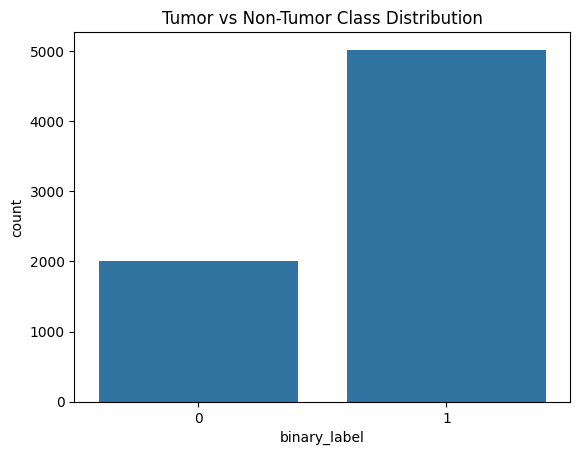

In [16]:
#Explore class balance
sns.countplot(x='binary_label', data=df)
plt.title("Tumor vs Non-Tumor Class Distribution")
plt.show()

In [17]:
#Determine class imbalance ratio
positive = (df.binary_label == 1).sum()
negative = (df.binary_label == 0).sum()
class_imbalance_ratio = positive/negative
print(f"The class imbalance ratio is {class_imbalance_ratio:.2f}")

The class imbalance ratio is 2.51


A class imbalance ratio of 2.51 is moderately imbalanced and can impact my model’s performance, especially during training. This is especially problematic in medical tasks, where false negatives (missed tumors) can be very costly since my tumor images outnumber non-tumor images.  

To help address this imbalance I will start by using class weights during my model training. Other techniques that I will consider if perfomance is still not great after using class weights include:  

* Oversampling
* Data Augmentation

In [18]:
#Explore possible class weights for training
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['binary_label']), y=df['binary_label'])

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.75575, 1: 0.6990842126219391}
